In [1]:
from imagenet.models import CGN
from imagenet.models.gp_gan import BlendNet

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision

In [3]:
cgn = CGN(1)
weights = torch.load("imagenet/weights/cgn.pth", map_location=torch.device('cpu'))
weights = {k.replace('module.', ''): v for k, v in weights.items()}
cgn.load_state_dict(weights)

<All keys matched successfully>

In [4]:
x_gt, mask, _, foreground, background, _ = cgn()
img_comp = mask * foreground + (1 - mask) * background

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Mask')

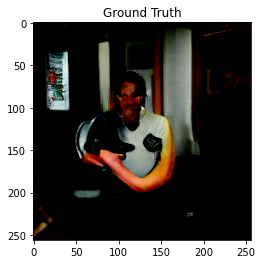

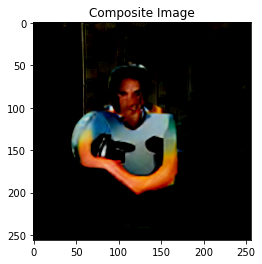

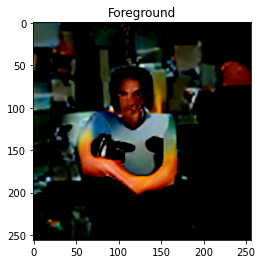

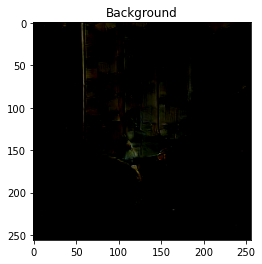

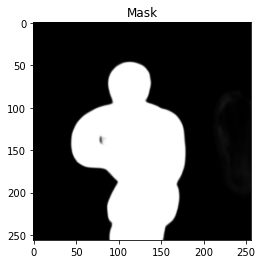

In [5]:
# printing the results
plt.imshow(x_gt.detach().squeeze(0).transpose(1,0).transpose(2,1))
plt.title('Ground Truth')
plt.figure()
plt.imshow(img_comp.detach().squeeze(0).transpose(1,0).transpose(2,1))
plt.title('Composite Image')
plt.figure()
plt.imshow(foreground.detach().squeeze(0).transpose(1,0).transpose(2,1))
plt.title('Foreground')
plt.figure()
plt.imshow(background.detach().squeeze(0).transpose(1,0).transpose(2,1))
plt.title('Background')
plt.figure()
plt.imshow(mask.detach().squeeze(), cmap='gray')
plt.title('Mask') 



In [14]:
# loading the blend net
model = BlendNet()

PATH = "imagenet/weights/blend_net_weights.pth" 
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


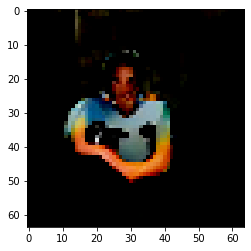

In [15]:
# model expects 64x64 imgs so resize...
img_resz = torchvision.transforms.functional.resize(img_comp, size=(64,64))
plt.imshow(img_resz.squeeze(0).detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


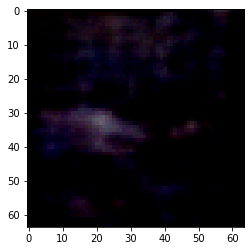

In [16]:
model.eval()
xl_from_net = model(img_resz)#.squeeze(0))
print(xl_from_net.size())
plt.imshow(xl_from_net.detach().squeeze(0).numpy().transpose(1,2,0))
print(xl_from_net.max())
print(xl_from_net.min())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


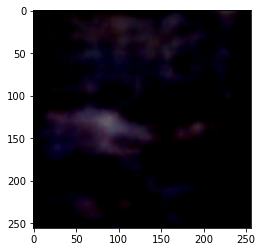

In [17]:
xl = torchvision.transforms.functional.resize(xl_from_net, size=(256,256))
plt.imshow(xl.detach().squeeze(0).numpy().transpose(1,2,0))

In [18]:
# from imagenet.train_bgan import save_sample_sheet

# save_sample_sheet(model, cgn, "imagenet/experiments", '0')

PermissionError: [Errno 13] Permission denied: '/home/lcur1339/dl2-cgn/cgn_framework/imagenet/experiments/blendnetinput.png'

: 